MovieWriter imagemagick unavailable; using Pillow instead.


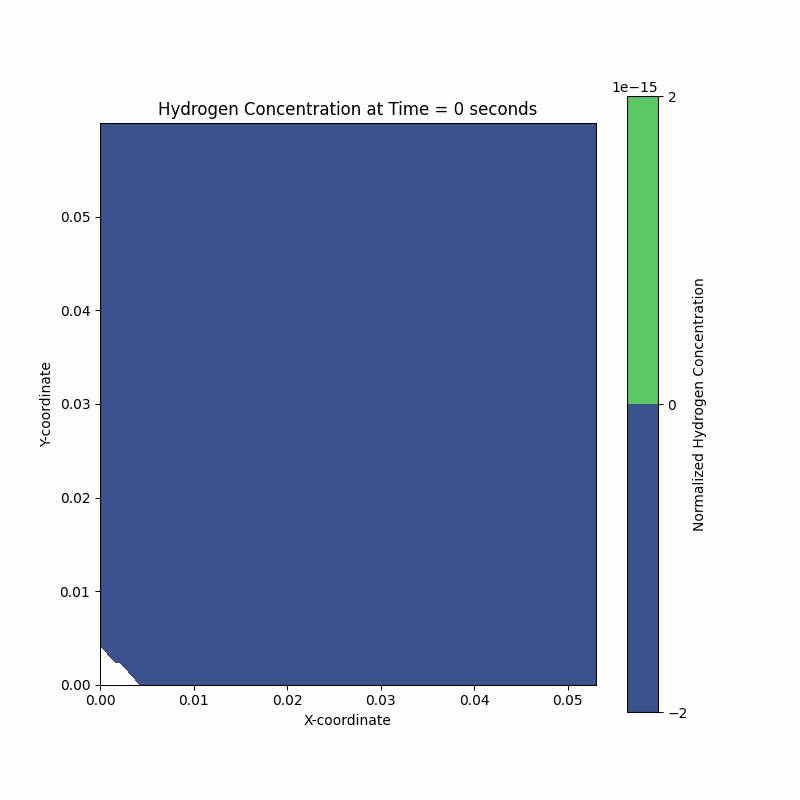

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
from IPython.display import Image, display

# Load the data
hydrogen_df = pd.read_excel("hydrogen_concentration.xlsx", sheet_name="hydrogen_concentration")
nodes_df = pd.read_excel("Nodes.xlsx", sheet_name="Sheet1")

# Prepare node positions
node_positions = nodes_df.copy()
node_positions['node'] = node_positions['node'].str.strip()

# Extract time steps and reshape hydrogen data
time_steps = hydrogen_df['time'].values
hydrogen_data = hydrogen_df.drop(columns='time').T  # Transpose to make nodes rows

# Extract coordinates and map node names to positions
node_coordinates = node_positions.set_index('node')[['x', 'y']]
coordinates = node_coordinates.values

# Ensure dimensions match for hydrogen concentrations
hydrogen_array = hydrogen_data.to_numpy()

# Normalize the hydrogen data for better visualization
normalized_hydrogen = (hydrogen_array - hydrogen_array.min()) / (hydrogen_array.max() - hydrogen_array.min())

# Create an interpolation grid
grid_x, grid_y = np.linspace(coordinates[:, 0].min(), coordinates[:, 0].max(), 100), \
                 np.linspace(coordinates[:, 1].min(), coordinates[:, 1].max(), 100)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Compute the convex hull of the data points
hull = Delaunay(coordinates)

# Create a mask for grid points within the convex hull
grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]
mask = hull.find_simplex(grid_points) >= 0
mask = mask.reshape(grid_x.shape)

# Function to interpolate data for each time step
def interpolate_concentration(frame):
    interpolated_data = griddata(
        (coordinates[:, 0], coordinates[:, 1]),  # Known (x, y) points
        normalized_hydrogen[:, frame],          # Corresponding hydrogen values
        (grid_x, grid_y),                       # Interpolation grid
        method='linear'                         # Smoothing method
    )
    interpolated_data[~mask] = np.nan  # Apply the convex hull mask
    return interpolated_data

# Initialize the plot
interpolated_data = interpolate_concentration(0)
fig, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(grid_x, grid_y, interpolated_data, levels=100, cmap='viridis')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label("Normalized Hydrogen Concentration")

ax.set_title(f"Hydrogen Concentration at Time = {time_steps[0]} seconds")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', 'box')

# Update function for the animation
def update(frame):
    ax.clear()  # Clear previous plot
    interpolated_data = interpolate_concentration(frame)
    contour = ax.contourf(grid_x, grid_y, interpolated_data, levels=100, cmap='viridis')
    ax.set_title(f"Hydrogen Concentration at Time = {time_steps[frame]} seconds")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    return contour

# Create the animation
anim = FuncAnimation(fig, update, frames=len(time_steps), interval=200, blit=False)

# Save the animation as a GIF
output_path = "hydrogen_concentration_interpolated.gif"
anim.save(output_path, writer="imagemagick")

plt.close(fig)  # Close the figure after saving
display(Image(filename=output_path))
